原理：https://blog.csdn.net/qq547276542/article/details/77865341

Code：https://blog.csdn.net/qq_30091945/article/details/54379922

In [1]:
import numpy as np
from pandas import Series
from pandas import DataFrame
import pandas as pd
import matplotlib.pyplot as plt


def Identification_Algorithm(x):    #辨识算法
    B = np.array([[1]*2]*5)
    tmp = np.cumsum(x)
    for i in range(len(x)-1):
        B[i][0] = ( tmp[i] + tmp[i+1] ) * (-1.0) / 2
    Y = np.transpose(x[1:])
    BT = np.transpose(B)
    a = np.linalg.inv(np.dot(BT,B))
    a = np.dot(a,BT)
    a = np.dot(a,Y)
    a = np.transpose(a)
    return a;

def GM_Model(X0,a,tmp):          #GM(1,1)模型
    A = np.ones(len(X0))
    for i in range(len(A)):
        A[i] = a[1]/a[0] + (X0[0]-a[1]/a[0])*np.exp(a[0]*(tmp[i]-1)*(-1))
    print ('GM(1,1)模型为:\nX(k) = ',X0[0]-a[1]/a[0],'exp(',-a[0],'(k-1))',a[1]/a[0])
    XK = Series(A,index=pd.period_range('2000','2005',freq = 'A-DEC'))   
    print ('GM(1,1)模型计算值为:')
    print (XK)
    return XK;

def Return(XK):                 #预测值还原
    tmp = np.ones(len(XK)) 
    for i in range(len(XK)):
        if i == 0:
            tmp[i] = XK[i]
        else:
            tmp[i] = XK[i] - XK[i-1]
    X_Return = Series(tmp,index=pd.period_range('2000','2005',freq = 'A-DEC'))
    print ('还原值为:\n')
    print (X_Return)
    return X_Return


In [3]:
pd.period_range('2000','2005',freq = 'A-DEC')

PeriodIndex(['2000', '2001', '2002', '2003', '2004', '2005'], dtype='period[A-DEC]', freq='A-DEC')

原始数据为:

2000    132
2001     92
2002    118
2003    130
2004    187
2005    207
Freq: A-DEC, dtype: int32
原始数据累加为:
2000    132
2001    224
2002    342
2003    472
2004    659
2005    866
Freq: A-DEC, dtype: int32
a矩阵为:
[ -0.20517488  56.72822646]
GM(1,1)模型为:
X(k) =  408.487188377 exp( 0.205174882772 (k-1)) -276.487188377
GM(1,1)模型计算值为:
2000    132.000000
2001    225.028773
2002    339.243896
2003    479.470343
2004    651.631928
2005    863.001549
Freq: A-DEC, dtype: float64
还原值为:

2000    132.000000
2001     93.028773
2002    114.215123
2003    140.226447
2004    172.161584
2005    211.369622
Freq: A-DEC, dtype: float64
预测值即预测值精度表
              GM  1—AGO  Returnvalue  Realityvalue      Error  \
2000  132.000000    132   132.000000           132   0.000000   
2001  225.028773    224    93.028773            92  -1.028773   
2002  339.243896    342   114.215123           118   3.784877   
2003  479.470343    472   140.226447           130 -10.226447   
2004  651.631928    659   172.16158

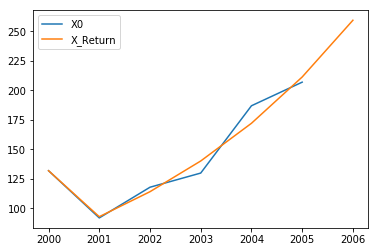

In [2]:
if __name__ == '__main__':
    #初始化原始数据
    date = pd.period_range('2000','2005',freq = 'A-DEC')
    tmp = np.array([1,2,3,4,5,6])
    data = np.array([132,92,118,130,187,207])
    X0 = Series(data,index = date)
    X0_copy = Series(data,index=tmp)
    print ('原始数据为:\n')
    print(X0)

    #对原始数据惊醒一次累加
    X1 = np.cumsum(X0)
    print ('原始数据累加为:')
    print(X1)

    #辨识算法
    a = Identification_Algorithm(data)
    print ('a矩阵为:')
    print (a)

    #GM(1,1)模型
    XK = GM_Model(X0,a,tmp)

    #预测值还原
    X_Return = Return(XK)

    #预测值即预测值精度表
    X_Compare1 = np.ones(len(X0))
    X_Compare2 = np.ones(len(X0))
    for i in range(len(data)):
        X_Compare1[i] = data[i]-X_Return[i]
        X_Compare2[i] = X_Compare1[i]/data[i]*100
    Compare = {'GM':XK,'1—AGO':np.cumsum(data),'Returnvalue':X_Return,'Realityvalue':data,'Error':X_Compare1,'RelativeError(%)':X_Compare2}
    X_Compare = DataFrame(Compare,index=date)
    print ('预测值即预测值精度表')
    print (X_Compare)

    #模型检验
    error_square = np.dot(X_Compare,np.transpose(X_Compare))    #残差平方和
    error_avg = np.mean(error_square)                           #平均相对误差

    S = 0                                                       #X0的关联度
    for i in range(1,len(X0)-1,1):
        S += X0[i]-X0[0]+(XK[-1]-XK[0])/2
    S = np.abs(S)

    SK = 0                                                      #XK的关联度
    for i in range(1,len(XK)-1,1):
        SK += XK[i]-XK[0]+(XK[-1]-XK[0])/2
    SK = np.abs(SK)

    S_Sub = 0                                                   #|S-SK|b
    for i in range(1,len(XK)-1,1):
        S_Sub += X0[i]-X0[0]-(XK[i]-XK[0])+((X0[-1]-X0[0])-(XK[i]-XK[0]))/2
    S_Sub = np.abs(S_Sub)

    T = (1+S+SK)/(1+S+SK+S_Sub)

    if T >= 0.9:
        print ('精度为一级')
        print ('可以用GM(1,1)模型\nX(k) = ',X0[0]-a[1]/a[0],'exp(',-a[0],'(k-1))',a[1]/a[0])
    elif T >= 0.8:
        print ('精度为二级')
        print ('可以用GM(1,1)模型\nX(k) = ',X0[0]-a[1]/a[0],'exp(',-a[0],'(k-1))',a[1]/a[0])
    elif T >= 0.7:
        print ('精度为三级')
        print ('谨慎用GM(1,1)模型\nX(k) = ',X0[0]-a[1]/a[0],'exp(',-a[0],'(k-1))',a[1]/a[0])
    elif T >= 0.6:
        print ('精度为四级')
        print ('尽可能不用GM(1,1)模型\nX(k) = ',X0[0]-a[1]/a[0],'exp(',-a[0],'(k-1))',a[1]/a[0])


    X2006 = Series(np.array([259.4489]),index=pd.period_range('2006','2006',freq = 'A-DEC'))
    X_Return = X_Return.append(X2006)
    print (X_Return)

    B = pd.DataFrame([X0,X_Return],index=['X0','X_Return'])
    B = np.transpose(B)
    B.plot()